In [250]:
#import modules
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_wine

# Import PySwarms
import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import plot_cost_history, plot_contour, plot_surface
import matplotlib.pyplot as plt

In [251]:
#Carregando dados 

data = load_wine()
X = data.data
y = data.target
np.size(y,0)

178

In [252]:
seed = 42
test_size = 0.3

In [253]:
#Treinamento e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


In [254]:
#Arquitetura da rede
n_inputs = 13 # features
n_hidden = 20 
n_classes = 3
num_samples = X_train.shape[0] 
num_samples

124

In [255]:
def logits_function(p,X_train):
    """ Calculate roll-back the weights and biases

    Inputs
    ------
    p: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    numpy.ndarray of logits for layer 2

    """
    #coeficientes
    c1 = n_hidden*n_inputs
    c2 = c1 +n_hidden
    c3 = c2 + (n_hidden*n_hidden)
    c4=  c3 + n_hidden
    c5 = c4+(n_hidden*n_classes)
    
     # First layer weights
    W1 = p[0:c1].reshape(n_inputs, n_hidden) - 1
    
    # First layer bias
    b1 = p[c1:c2].reshape(( n_hidden,))
    
    # Second layer weights
    W2 = p[c2:c3].reshape(n_hidden, n_hidden) - 1
    
    # Second layer bias
    b2 = p[c3:c4].reshape(( n_hidden,))
    W3 = p[c4:c5].reshape(n_hidden, n_classes) - 1
    b3 = p[c5:c5+n_classes].reshape((n_classes,))
    

    # Perform forward propagation
    z1 = X_train.dot(W1) + b1  # Pre-activation in Layer 1
    a1 = np.tanh(z1)     # Activation in Layer 1
    
    # Second linear step
    z2 = a1.dot(W2) + b2
    
    # Second activation function
    a2 = np.tanh(z2)
    
    #Third linear step
    z3 = a2.dot(W3) + b3
    
    #For the Third linear activation function we use the softmax function, either the sigmoid of softmax should be used for the last layer
    logits = z3
   
      
    
    
    
    return logits          # Logits for Layer 2

In [256]:
# Forward propagation
def forward_prop(params):
    """Forward propagation as objective function

    This computes for the forward propagation of the neural network, as
    well as the loss.

    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the
        weights and biases.

    Returns
    -------
    float
        The computed negative log-likelihood loss given the parameters
    """

    logits = logits_function(params,X_train)

    # Compute for the softmax of the logits
    exp_scores = np.exp(logits)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # Compute for the negative log likelihood

    corect_logprobs = -np.log(probs[range(num_samples), y_train])
    loss = np.sum(corect_logprobs) / num_samples
    #print(loss)
    return loss

In [257]:
def f(x):
    """Higher-level method to do forward_prop in the
    whole swarm.

    Inputs
    ------
    x: numpy.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search

    Returns
    -------
    numpy.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    
    n_particles = x.shape[0]
    j = [forward_prop(x[i]) for i in range(n_particles)]
    #print(x)
    return np.array(j)

2021-07-10 18:11:26,877 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|████████████████████████████████████████████████████████|1000/1000, best_cost=4.82e-7
2021-07-10 18:12:05,096 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.821431022297255e-07, best pos: [-8.11413266e-01 -1.79400793e-01  9.85144642e-01  8.99308505e-01
  2.03026164e+00  1.13724121e+00  6.44268848e-01  1.26315146e+00
 -7.35810814e-02  5.74360411e-01  1.57577696e+00  1.14571261e+00
  7.22678819e-01  2.12099372e+00  1.33723241e+00  9.18066991e-04
  2.08228436e-01  2.19956625e-01 -5.03606693e-01  6.72280303e-01
  1.23340901e+00 -4.88783416e-02  2.19178976e+00 -3.01897554e-01
  4.90577866e-01  1.13908957e+00  6.89912379e-01  1.01831381e+00
  1.57667625e+00 -2.40946794e-02  1.02268576e+00  4.15257184e+00
 -3.80644385e-01  1.39100387e+00  4.10354043e-01  2.71273019e+00
  1.79362979e-01  3.42572559e-01  7.922

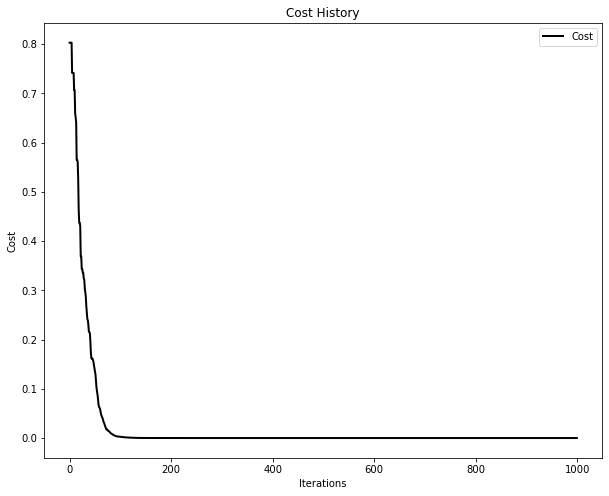

Wall time: 38.6 s


In [258]:
%%time
# Initialize swarm
options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}

# Call instance of PSO
dimensions = (n_inputs * n_hidden) + (n_hidden * n_hidden)+(n_hidden*n_classes) + 2*n_hidden + n_classes
optimizer = ps.single.GlobalBestPSO(n_particles=100, dimensions=dimensions, options=options)

# Perform optimization
cost, pos = optimizer.optimize(f, iters=1000)

# Plot the cost
plot_cost_history(optimizer.cost_history)
plt.show()


In [259]:
def predict(pos):
    """
    Use the trained weights to perform class predictions.

    Inputs
    ------
    pos: numpy.ndarray
        Position matrix found by the swarm. Will be rolled
        into weights and biases.
    """
    logits = logits_function(pos,X_test)
    
    y_pred = np.argmax(logits, axis=1)
   
    return y_pred

In [260]:
(predict(pos) == y_test).mean()

0.9629629629629629